In [9]:
import random
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from configobj import ConfigObj
config = ConfigObj('config')

ml_home = config.get(
    'ml_home', '/')
sys.path.append('../../util')
sys.path.append(ml_home)
sys.path.append(ml_home+ '/features')
sys.path.append(ml_home+ '/eda')
sys.path.append(ml_home+ '/model_evaluation')
import trees_helper
import plot_helper
import model_eval_plot
import myutil
import ml_util  
import features
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)
%matplotlib inline
sys.path.append('credit')

In [10]:
from sklearn.ensemble import GradientBoostingClassifier,  RandomForestClassifier
from sklearn.metrics import roc_curve, classification_report, roc_auc_score
from sklearn.cross_validation import train_test_split
import numpy as np
import time

In [11]:
from eda_uti import *

In [12]:
flag_test = 0

fname = 'data/credit-training.csv'
if flag_test:
    fname = 'data/credit-training_sample.csv'
df = read_all_data(fname)
df, xnames, yname = pre_process(df)


original column names:
Index([u'unnamed: 0', u'serious_dlqin2yrs',
       u'revolving_utilization_of_unsecured_lines', u'age',
       u'number_of_time30-59_days_past_due_not_worse', u'debt_ratio',
       u'monthly_income', u'number_of_open_credit_lines_and_loans',
       u'number_of_times90_days_late', u'number_real_estate_loans_or_lines',
       u'number_of_time60-89_days_past_due_not_worse',
       u'number_of_dependents'],
      dtype='object')
read in columns:
Index([                 u'id',           u'dlqin2yrs',                 u'age',
        u'revolv_util_clines',                 u'dti',      u'monthly_income',
       u'n_loans_creditlines',       u'n_house_loans',        u'n_dependents',
             u'n_30-59d_late',       u'n_60-89d_late',          u'n_90d_late'],
      dtype='object')


In [13]:
yname = 'dlqin2yrs'

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df[xnames], df[yname], test_size=0.2)
X_train, scaler = scale_X(X_train, xnames)
X_test = scale_X_transform( X_test, xnames, scaler)

In [19]:
clf1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=2000 \
    , max_features = 6, min_samples_split = 15, max_depth = 5, min_samples_leaf = 16)
clf2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=2000 \
    , max_features = 6, min_samples_split = 15, max_depth = 5, min_samples_leaf = 16
    , subsample = 0.3)
clf3 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=2000 \
    , max_features = 6, min_samples_split = 15, max_depth = 5, min_samples_leaf = 16
    , subsample = 0.8)
clfs = [clf1, clf2,clf3]

for i in xrange(len(clfs)):
    t0 = time.time()
    clfs[i].fit(X_train, y_train)
    t1 = time.time() # time it
    time_taken = (t1-t0)/60	
    print i,' finished in ', time_taken, ' minutes'    

0  finished in  27.0435363332  minutes
1  finished in  14.1704580307  minutes
2  finished in  13.2244396488  minutes


0  finished in  4.57584901651  minutes
1  finished in  5.34226915042  minutes
2  finished in  6.3545606335  minutes


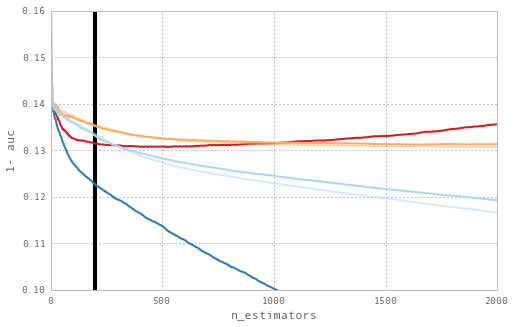

In [35]:
func_score = roc_auc_score
fig = plt.figure(figsize=(8, 5))
ax = plt.gca()

labels = ['learning rate 0.05','subsample 0.3, learning rate 0.01','subsample 0.8, learning rate 0.01' ]
colors = [('#d7191c', '#2c7bb6'), ('#fdae61', '#abd9e9'), ('#fdae61', '#abd9e9')]
alphas = [1.0, 1.0, 0.5]
test_scores, train_scores = [],[]
for i in xrange(len(clfs)):
    t0 = time.time()
    alpha = alphas[i]
    test_color, train_color = colors[i]
    test_score, train_score, ax = trees_helper.plot_staged_score(clfs[i], X_test, X_train, y_test, y_train, func_score\
             , ax = ax, label=labels[i], ylabel ='1- auc', alpha=alpha
             , test_color = test_color, train_color = train_color)
    test_scores.append(test_score)
    train_scores.append(train_score)
    t1 = time.time() # time it
    time_taken = (t1-t0)/60
    print i,' finished in ', time_taken, ' minutes'    
ax.set_ylim(0.1, 0.16)
ax.vlines(200, 0.10, 0.16, colors='k', lw=4)
#plt.legend()
#plt.show()

In [36]:
ax.vlines(200, 0.10, 0.16, colors='k', lw=2)


In [18]:
gbc = GradientBoostingClassifier(learning_rate=0.05, n_estimators=400 \
    , max_features = 6, min_samples_split = 15, max_depth = 5, min_samples_leaf = 16)

In [19]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
              max_depth=5, max_features=6, max_leaf_nodes=None,
              min_samples_leaf=16, min_samples_split=15,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

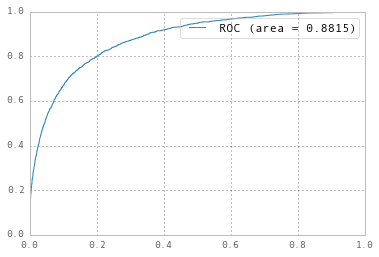

In [26]:
y_test_pred = gbc.predict_proba(X_test)
model_eval_plot.plot_roc(y_test, y_test_pred)
plt.legend()
plt.show()

In [21]:
gbc.fit(df[xnames], df[yname])

GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
              max_depth=5, max_features=6, max_leaf_nodes=None,
              min_samples_leaf=16, min_samples_split=15,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

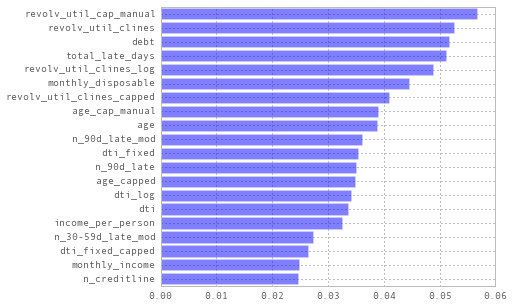

In [28]:
fig = model_eval_plot.plot_feature_importance_gbc(gbc, xnames, topk = 20, figsize = (6,5) )

In [23]:
rfc_params = {'min_samples_leaf': 7, 'min_samples_split': 3, \
                  'criterion': 'entropy', 'max_features': 9, 'max_depth': 11,\
                  'class_weight': {0: 1, 1: 1}, 'n_estimators': 300}
rfc = RandomForestClassifier(**rfc_params)

 finished in  6.01813376745  minutes


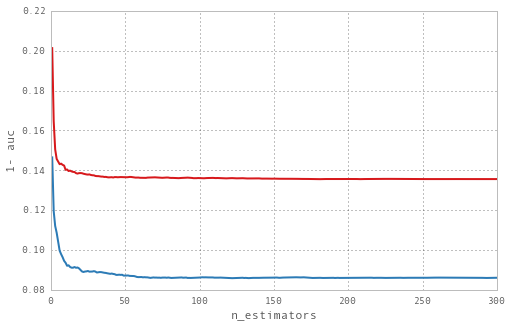

In [24]:
train_color, test_color = ( '#2c7bb6','#d7191c') 
t0 = time.time() # time it
rfc.fit(X_train, y_train)
test_score, ax = trees_helper.plot_staged_score_rf(rfc, X_test, X_train, y_test, y_train, func_score\
             , label=labels[i], ylabel ='1- auc', alpha=1.0
             , test_color = test_color, train_color = train_color)
t1 = time.time() # time it
time_taken = (t1-t0)/60
print ' finished in ', time_taken, ' minutes' 

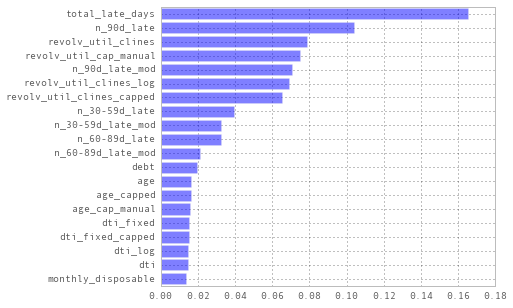

In [30]:
rfc.fit(df[xnames], df[yname])
fig = model_eval_plot.plot_feature_importance(rfc, xnames, topk = 20, figsize = (6,5))

## final model

In [31]:
import credit

In [33]:
weight = [0.5, 0.5]
credit.apply_fitted_models(weight, [gbc, rfc])

original column names:
Index([u'unnamed: 0', u'serious_dlqin2yrs',
       u'revolving_utilization_of_unsecured_lines', u'age',
       u'number_of_time30-59_days_past_due_not_worse', u'debt_ratio',
       u'monthly_income', u'number_of_open_credit_lines_and_loans',
       u'number_of_times90_days_late', u'number_real_estate_loans_or_lines',
       u'number_of_time60-89_days_past_due_not_worse',
       u'number_of_dependents'],
      dtype='object')
read in columns:
Index([                 u'id',           u'dlqin2yrs',                 u'age',
        u'revolv_util_clines',                 u'dti',      u'monthly_income',
       u'n_loans_creditlines',       u'n_house_loans',        u'n_dependents',
             u'n_30-59d_late',       u'n_60-89d_late',          u'n_90d_late'],
      dtype='object')
